In [1]:
import os,torch,logging
from datasets.things_eeg import EEGDataset
from torch.utils.data import DataLoader
from models.ae import Autoencoder,Autoencoder_MLP
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
config = {
    "device":torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "data_dir": "/dev/shm/datasets/things-eeg-small/Preprocessed_data_250Hz",
    "exp_root":'./exp',
    "name": 'eeg_mae_mlp',
    "lr": 1e-4,
    "epochs": 100,
    "batch_size": 12,
    "model_type":'ViT-B/32',
    "logger": True,
    "subjects":['sub-08'],#'sub-02','sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10'],
    "eeg_model":{'name':'Autoencoder_MLP','args':{}}#"eeg_model":{'name':'Autoencoder','args':{'patch_size':25,'mlp_ratio':1.0}},
}
config['exp_dir'] = os.path.join(config['exp_root'],config['name'])
test_dataset = EEGDataset(data_dir=config['data_dir'],subjects=config['subjects'],model_type=config['model_type'],mode='test')
train_dataset = EEGDataset(data_dir=config['data_dir'],subjects=config['subjects'],model_type=config['model_type'],mode='train')

logging.info(f"train num: {len(train_dataset)}, test num: {len(test_dataset)}")
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False, drop_last=False,num_workers=12)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False, drop_last=True, num_workers=12, pin_memory=True)

data={ 
    'train':train_loader,
    'test':test_loader,
}
model = {
    'eeg':globals()[config['eeg_model']['name']](**config['eeg_model']['args']).to(config['device']),
}
model['eeg'].load_state_dict(torch.load(os.path.join(config['exp_dir'],'ckpt.pth'),map_location=config['device'])['eeg'])

for k,v in model.items():
    v.eval()

----load /dev/shm/datasets/things-eeg-small/Preprocessed_data_250Hz/sub-08/test.pt----
----load /dev/shm/datasets/things-eeg-small/Preprocessed_data_250Hz/sub-08/train.pt----


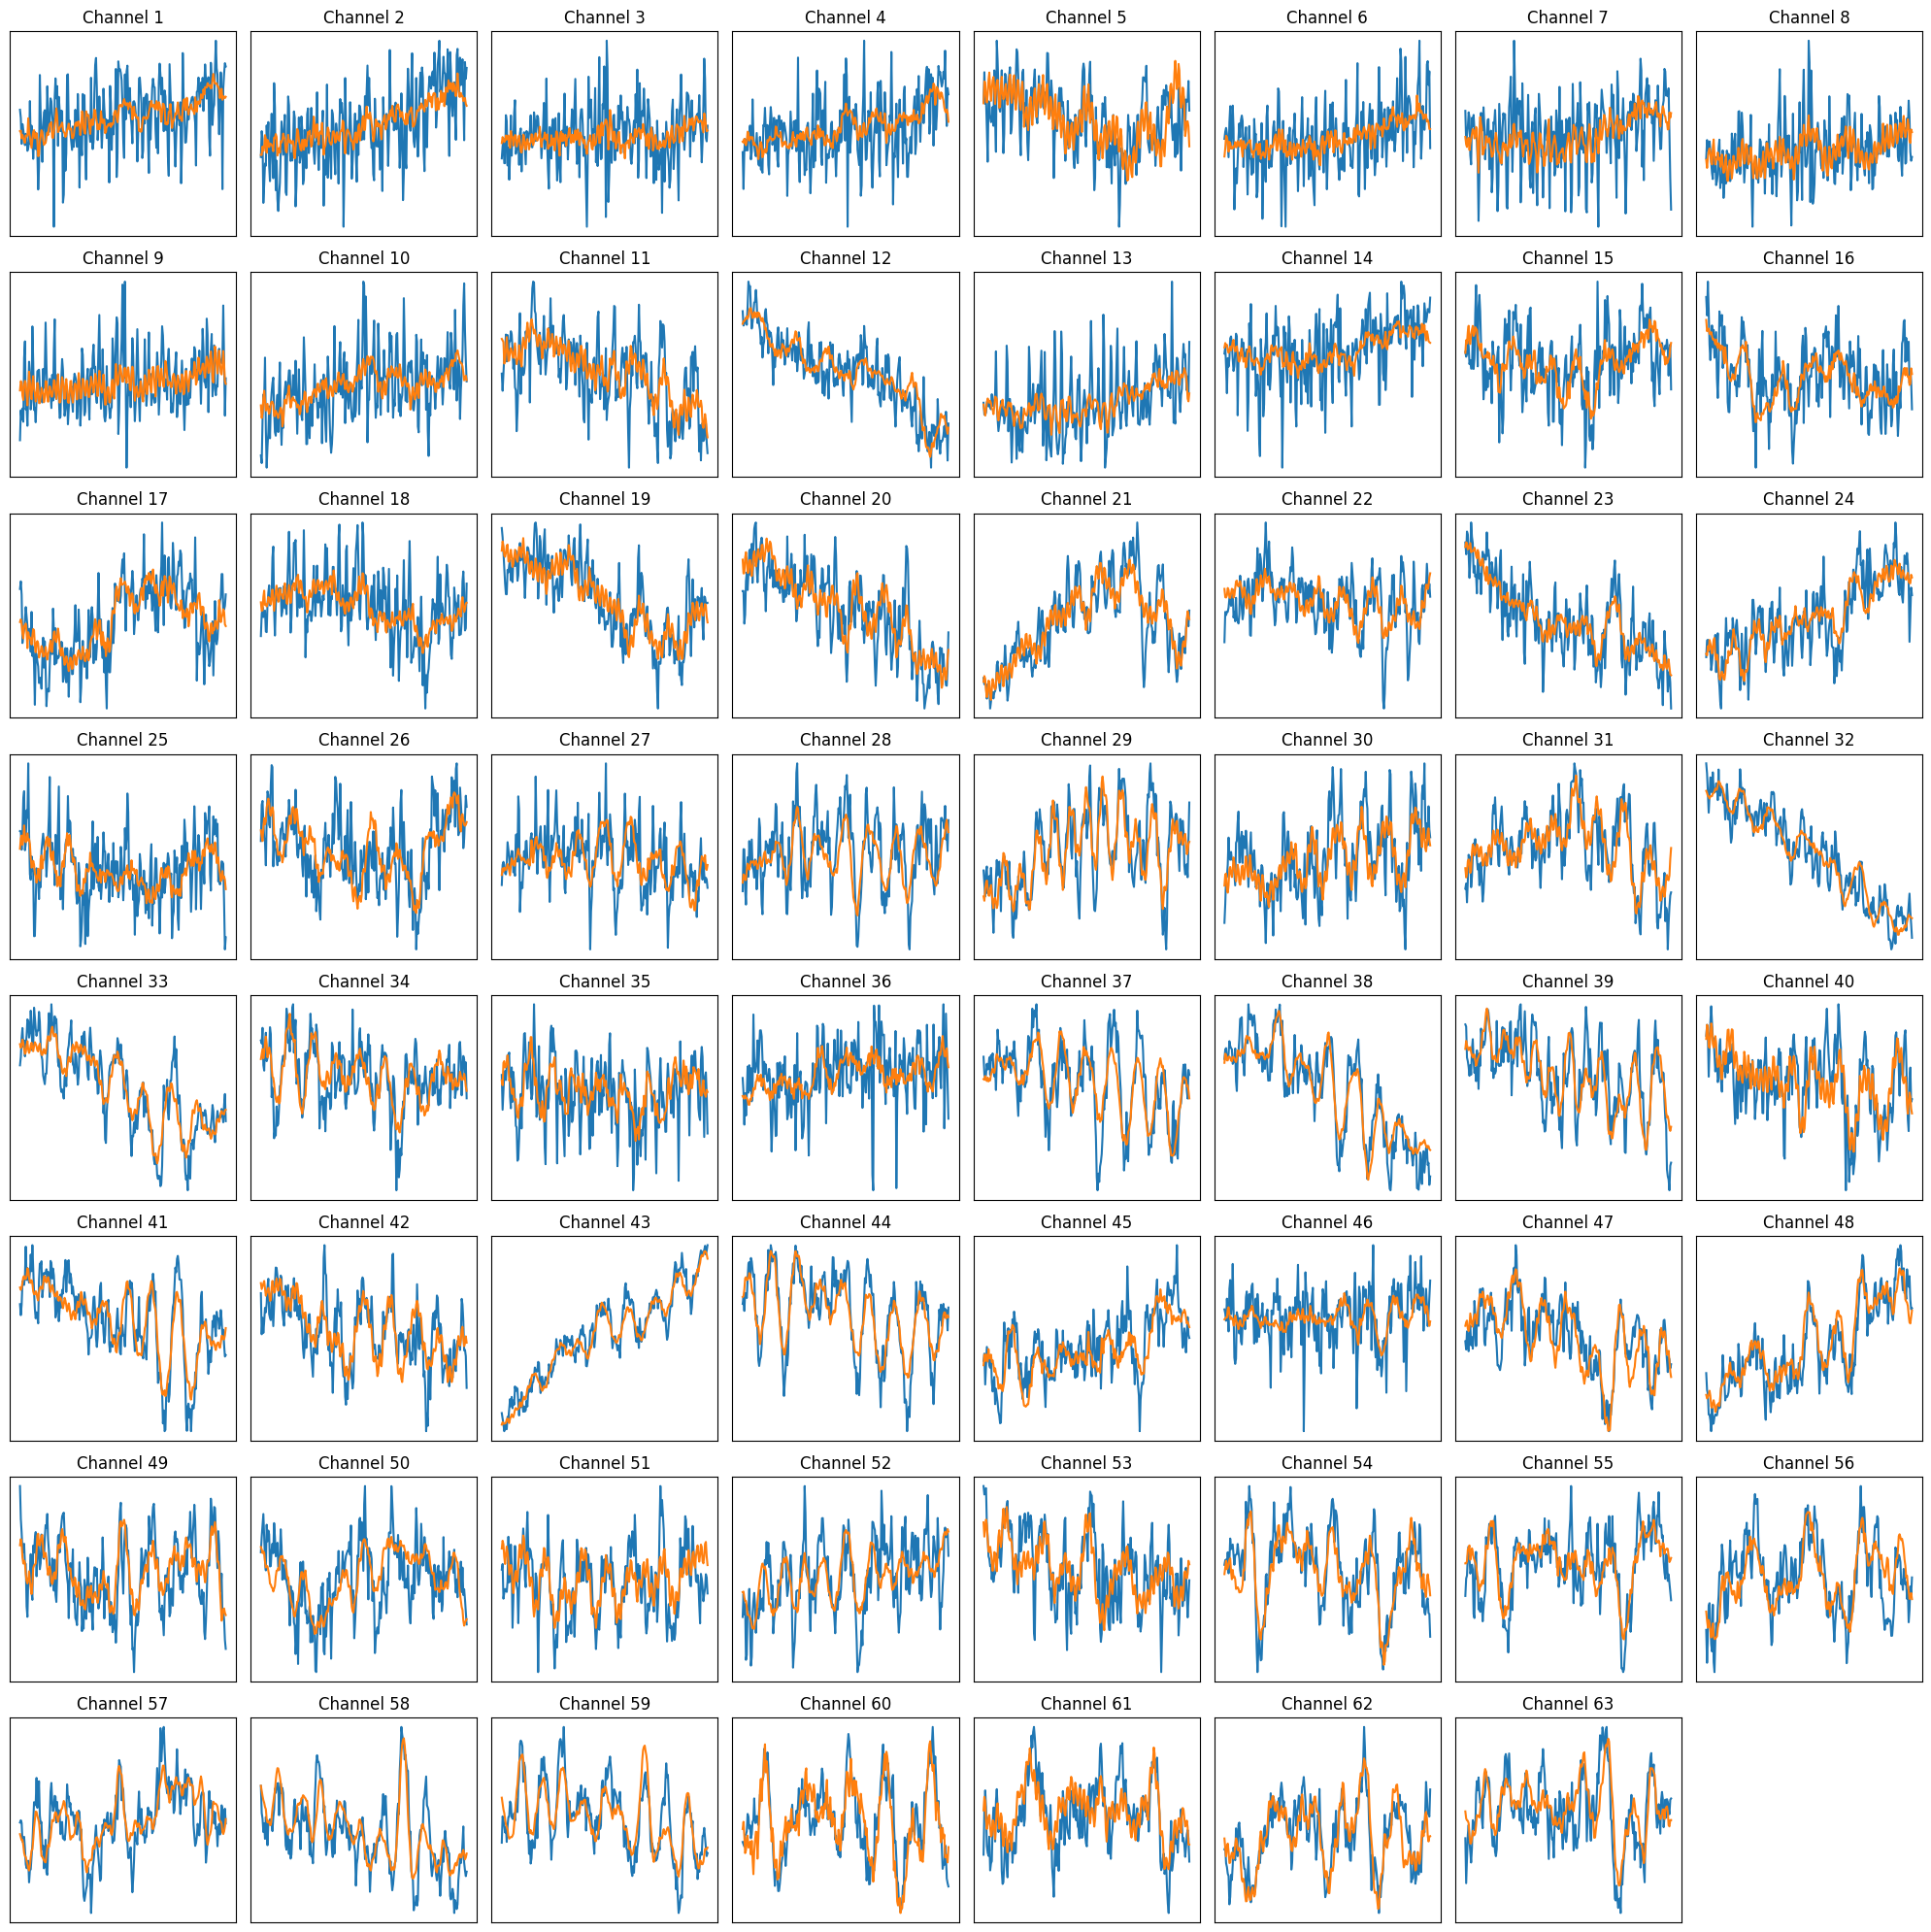

In [3]:
device = config['device']
loss_list=[]
mode = 'train'
for i,sample in enumerate(data[mode]):
    eeg, label, img, img_features,text, text_features,session,subject = sample #x:[63, 250], label:1024 text:text text_features:[1024, 1024] img:1024 img_features:[1024, 1024]
    eeg = eeg.to(device)
    with torch.no_grad(): 
        loss, pred, mask = model['eeg'](eeg)
        recon = model['eeg'].unpatchify(pred)
    break
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))
sample_id = 0
for i in range(63):
    row = i // 8  # 计算行索引
    col = i % 8   # 计算列索引
    ax = axes[row, col]
    
    ax.plot(eeg[sample_id][i].cpu())
    ax.plot(recon[sample_id][i].cpu())
    
    ax.set_title(f"Channel {i+1}")
    ax.set_xticks([]) 
    ax.set_yticks([])
axes[7, 7].axis('off')
plt.tight_layout()

name = 'time_domain'
# plt.savefig(f'./results/{name}_{mode}_all.pdf', format='pdf', bbox_inches='tight')
# plt.savefig(f'./results/{name}_{mode}_all.png', bbox_inches='tight')

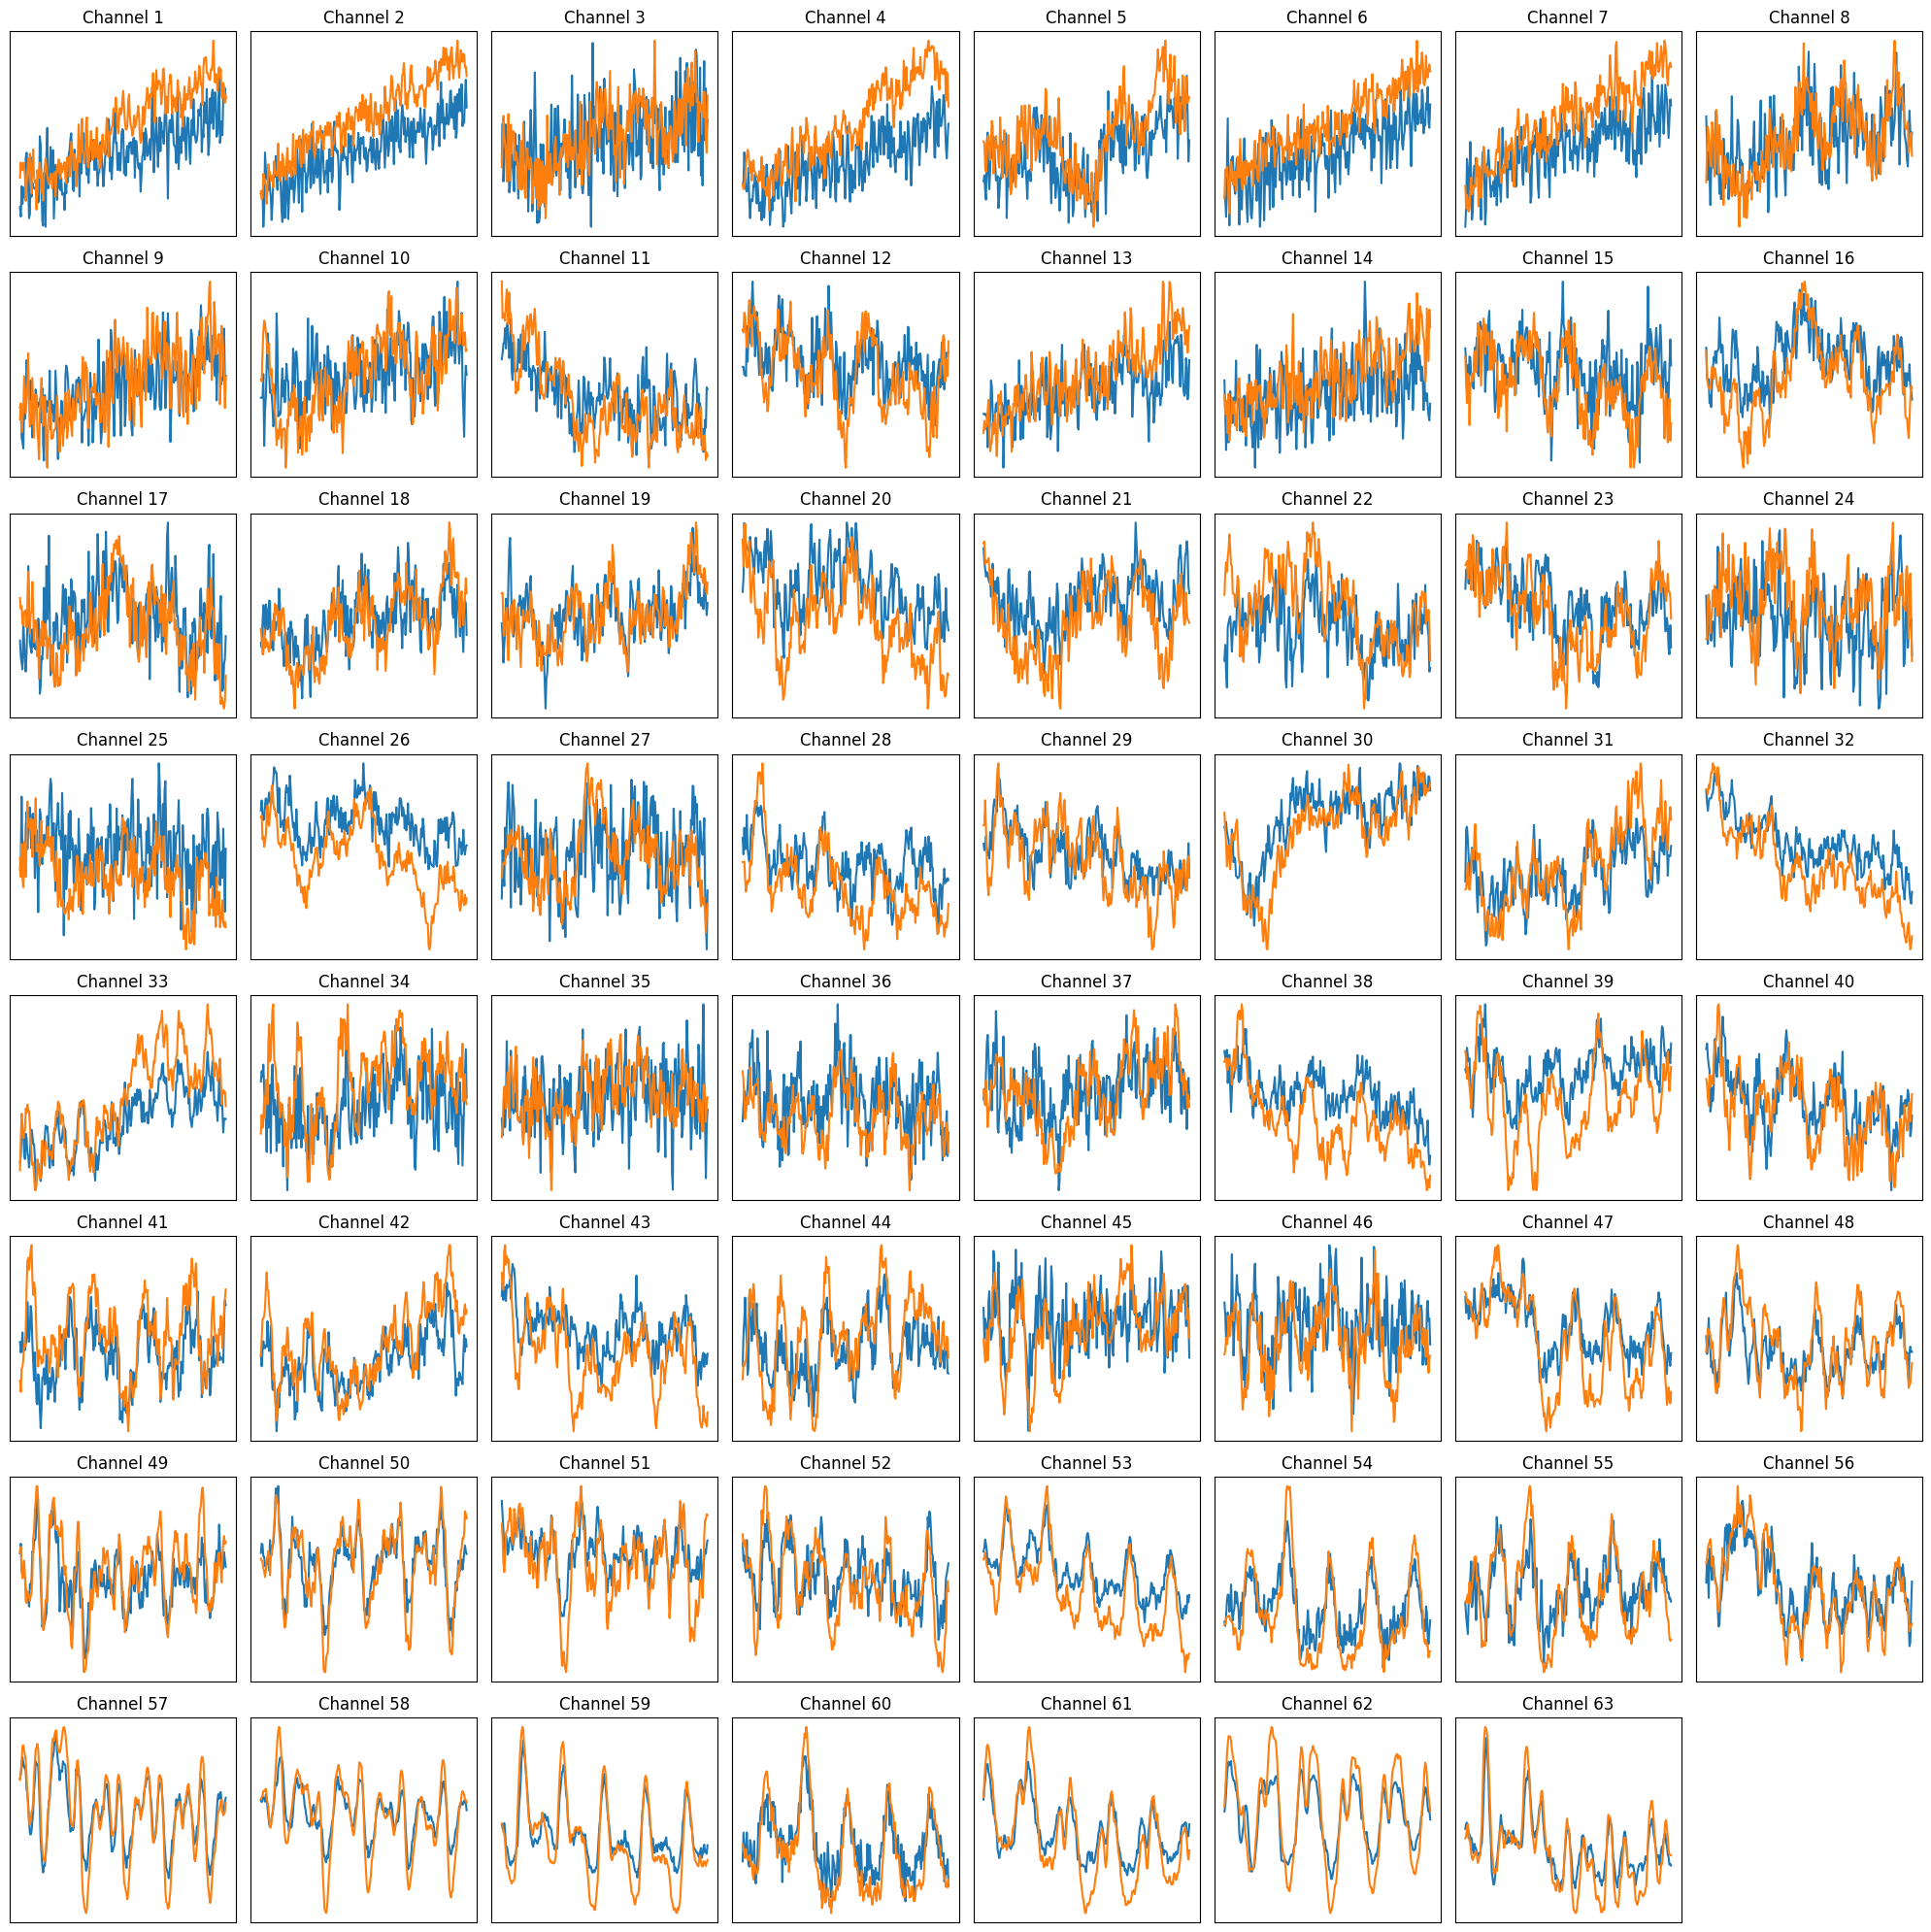

In [4]:
device = config['device']
loss_list=[]
mode = 'test'
for i,sample in enumerate(data[mode]):
    eeg, label, img, img_features,text, text_features,session,subject = sample #x:[63, 250], label:1024 text:text text_features:[1024, 1024] img:1024 img_features:[1024, 1024]
    eeg = eeg.to(device)
    with torch.no_grad(): 
        loss, pred, mask = model['eeg'](eeg)
        recon = model['eeg'].unpatchify(pred)
    break
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))
sample_id = 0
for i in range(63):
    row = i // 8  # 计算行索引
    col = i % 8   # 计算列索引
    ax = axes[row, col]
    
    ax.plot(eeg[sample_id][i].cpu())
    ax.plot(recon[sample_id][i].cpu())
    
    ax.set_title(f"Channel {i+1}")
    ax.set_xticks([])  
    ax.set_yticks([]) 
axes[7, 7].axis('off')
plt.tight_layout()

name = 'time_domain'
# plt.savefig(f'./results/{name}_{mode}_all.pdf', format='pdf', bbox_inches='tight')
# plt.savefig(f'./results/{name}_{mode}_all.png', bbox_inches='tight')

In [ ]:
device = config['device']
loss_list=[]
mode = 'test'
for i,sample in enumerate(data[mode]):
    eeg, label, img, img_features,text, text_features,session,subject = sample #x:[63, 250], label:1024 text:text text_features:[1024, 1024] img:1024 img_features:[1024, 1024]
    eeg = eeg.to(device)
    with torch.no_grad(): 
        loss, pred, mask = model['eeg'](eeg,mask_ratio=0.)
        recon = model['eeg'].unpatchify(pred)
    break
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))
sample_id = 0
for i in range(63):
    row = i // 8  # 计算行索引
    col = i % 8   # 计算列索引
    ax = axes[row, col]
    
    ax.plot(eeg[sample_id][i].cpu())
    ax.plot(recon[sample_id][i].cpu())
    
    ax.set_title(f"Channel {i+1}")
    ax.set_xticks([])  
    ax.set_yticks([]) 
axes[7, 7].axis('off')
plt.tight_layout()

name = 'time_domain'
plt.savefig(f'./results/{name}_{mode}.pdf', format='pdf', bbox_inches='tight')
plt.savefig(f'./results/{name}_{mode}.png', bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))
sample_id = 0
for i in range(63):
    row = i // 8  # 计算行索引
    col = i % 8   # 计算列索引
    ax = axes[row, col]
    ax.plot(eeg[sample_id][i].cpu())
    ax.plot(recon[sample_id][i].detach().cpu())
    ax.set_title(f"Channel {i+1}")
    ax.set_xticks([])  
    ax.set_yticks([]) 
axes[7, 7].axis('off')
plt.tight_layout()

name = 'time_domain'
plt.savefig(f'./results/{name}.pdf', format='pdf', bbox_inches='tight')
plt.savefig(f'./results/{name}.png', bbox_inches='tight')
# plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))
sample_id = 0
for i in range(63):
    row = i // 8  # 计算行索引
    col = i % 8   # 计算列索引
    ax = axes[row, col]
    ax.plot(eeg[sample_id][i].cpu())
    ax.plot(recon[sample_id][i].detach().cpu())
    ax.set_title(f"Channel {i+1}")
    ax.set_xticks([])  
    ax.set_yticks([]) 
axes[7, 7].axis('off')
plt.tight_layout()

name = 'time_domain'
plt.savefig(f'./results/{name}.pdf', format='pdf', bbox_inches='tight')
plt.savefig(f'./results/{name}.png', bbox_inches='tight')
# plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
sampling_rate = 250  # 采样率（Hz）
T = 1.0 / sampling_rate
t = np.linspace(0.0, 1.0, sampling_rate)  # 时间轴

fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))
for i in range(63):
    row = i // 8  # 计算行索引
    col = i % 8   # 计算列索引
    ax = axes[row, col]
    
    signal = eeg[0][i].cpu()
    # 进行傅里叶变换
    yf = np.fft.fft(signal)
    xf = np.fft.fftfreq(len(t), T)

    # 只取正频率部分
    xf = xf[:len(xf)//2]
    yf = yf[:len(yf)//2]

    # # 绘制时域信号

    # plt.subplot(2, 1, 1)
    # plt.plot(t, signal)
    # plt.title('Time domain')
    # plt.xlabel('Time (s)')
    # plt.ylabel('Amplitude')

    # 绘制频域信号
    # ax.plot(xf, 2.0/len(signal) * np.abs(yf))
    ax.plot(xf, yf)
    
    ax.set_title(f"Channel {i+1}")
    ax.set_xticks([])
    ax.set_yticks([])
    
axes[7, 7].axis('off')
plt.tight_layout()
# plt.show()
name = "frequency_domain"
plt.savefig(f'./results/{name}.pdf', format='pdf', bbox_inches='tight')
plt.savefig(f'./results/{name}.png', bbox_inches='tight')

In [ ]:
eeg[0][i].shape
signal = eeg[0].cpu()
fft_data = np.fft.fft(signal, axis=1)
fft_data.shape

In [ ]:
magnitude_spectrum = np.abs(fft_data)
magnitude_spectrum.shape

In [ ]:
yf